In [1]:
# Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, RobustScaler

# set random state
random_seed = 12345
# set style for plots
sns.set_style("white")

## Getting data

The code used to select and merge relevant data

In [2]:
"""
# load the index file and select the relevant columns
df_index = pd.read_csv('index.csv')
df_index = df_index[['location_key', 'country_name', 'subregion1_name']]

# fill the missing region names with the country name and drop missing values
df_index['subregion1_name'] = df_index['subregion1_name'].fillna(df_index['country_name'])
df_index.dropna()

# load the demographics data, select important columns and drop missing values
demo = pd.read_csv('demographics.csv')
demo = demo[['location_key', 'population']].dropna()

# load the geography data, select important columns and drop missing values
geo = pd.read_csv('geography.csv')
geo = geo[['location_key', 'latitude', 'longitude', 'area_sq_km']].dropna()

# load the epidemiology data, select important columns
epid = pd.read_csv('epidemiology.csv')
epid =  epid[['location_key', 'cumulative_confirmed', 'cumulative_deceased', 'cumulative_recovered', 'cumulative_tested']]
# This data had daily cummulative metrics for each location, but we only need the max numbers
# get the maximum metrics (e.g. most number of cummulative case, tests, etc) for each unique region/location and drop missing values
epid = epid.groupby('location_key').max().reset_index().dropna()

# load the hospitalization data, select key columns, and get the metrics for each location
hosp = pd.read_csv('hospitalizations.csv')
hosp = hosp[['location_key','cumulative_hospitalized_patients', 'cumulative_intensive_care_patients']]
hosp = hosp.groupby('location_key').max().reset_index().dropna()
"""

"\n# load the index file and select the relevant columns\ndf_index = pd.read_csv('index.csv')\ndf_index = df_index[['location_key', 'country_name', 'subregion1_name']]\n\n# fill the missing region names with the country name and drop missing values\ndf_index['subregion1_name'] = df_index['subregion1_name'].fillna(df_index['country_name'])\ndf_index.dropna()\n\n# load the demographics data, select important columns and drop missing values\ndemo = pd.read_csv('demographics.csv')\ndemo = demo[['location_key', 'population']].dropna()\n\n# load the geography data, select important columns and drop missing values\ngeo = pd.read_csv('geography.csv')\ngeo = geo[['location_key', 'latitude', 'longitude', 'area_sq_km']].dropna()\n\n# load the epidemiology data, select important columns\nepid = pd.read_csv('epidemiology.csv')\nepid =  epid[['location_key', 'cumulative_confirmed', 'cumulative_deceased', 'cumulative_recovered', 'cumulative_tested']]\n# This data had daily cummulative metrics for eac

In [3]:
"""
# Merge all the dataframes into one
merged_df = pd.merge(left=df_index, right=epid, how='left', on='location_key')
merged_df = pd.merge(left=merged_df, right=demo, how='left', on='location_key')
merged_df = pd.merge(left=merged_df, right=geo, how='left', on='location_key')
merged_df = pd.merge(left=merged_df, right=hosp, how='left', on='location_key')

# drop all missing values (they can't be with mean or median e.tc. since it won't make much sense)
merged_df = merged_df.dropna()

# Rearrage the columns in the preferred order
merged_df = merged_df[['location_key', 'country_name', 'subregion1_name', 'latitude', 'longitude', 'area_sq_km', 'population', 
                       'cumulative_confirmed', 'cumulative_deceased', 'cumulative_recovered', 'cumulative_tested',
                      'cumulative_hospitalized_patients', 'cumulative_intensive_care_patients']]

# reset the index to count from zero
merged_df = merged_df.reset_index(drop=True)

# save the merged df as a csv file
merged_df.to_csv("covid-19_data.csv")
"""

'\n# Merge all the dataframes into one\nmerged_df = pd.merge(left=df_index, right=epid, how=\'left\', on=\'location_key\')\nmerged_df = pd.merge(left=merged_df, right=demo, how=\'left\', on=\'location_key\')\nmerged_df = pd.merge(left=merged_df, right=geo, how=\'left\', on=\'location_key\')\nmerged_df = pd.merge(left=merged_df, right=hosp, how=\'left\', on=\'location_key\')\n\n# drop all missing values (they can\'t be with mean or median e.tc. since it won\'t make much sense)\nmerged_df = merged_df.dropna()\n\n# Rearrage the columns in the preferred order\nmerged_df = merged_df[[\'location_key\', \'country_name\', \'subregion1_name\', \'latitude\', \'longitude\', \'area_sq_km\', \'population\', \n                       \'cumulative_confirmed\', \'cumulative_deceased\', \'cumulative_recovered\', \'cumulative_tested\',\n                      \'cumulative_hospitalized_patients\', \'cumulative_intensive_care_patients\']]\n\n# reset the index to count from zero\nmerged_df = merged_df.reset_

## Data Loading and Exploration

In [4]:
# load the data, set the index as column 0
df = pd.read_csv('covid-19_data.csv', index_col=0)
df.head()

,location_key,country_name,subregion1_name,latitude,longitude,area_sq_km,population,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested,cumulative_hospitalized_patients,cumulative_intensive_care_patients
0,BR,Brazil,Brazil,-14.000000,-53.000000,8515770.0,212559409.0,34568833.0,685203.0,33706231.0,70923215.0,1204801.0,384172.0
1,BR_AC,Brazil,Acre,-9.047778,-70.526389,152581.0,733559.0,149529.0,2029.0,0.0,230496.0,2721.0,264.0
2,BR_AC_120001,Brazil,Acre,-9.827778,-66.882778,1.0,12538.0,3235.0,40.0,0.0,7760.0,111.0,16.0
3,BR_AC_120005,Brazil,Acre,-10.911389,-69.582500,2.0,6072.0,2156.0,25.0,0.0,4543.0,11.0,4.0
4,BR_AC_120010,Brazil,Acre,-11.010000,-68.747778,3.0,21398.0,3956.0,51.0,0.0,9456.0,17.0,6.0


In [5]:
df.shape

(5608, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5608 entries, 0 to 5607
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   location_key                        5608 non-null   object 
 1   country_name                        5608 non-null   object 
 2   subregion1_name                     5608 non-null   object 
 3   latitude                            5608 non-null   float64
 4   longitude                           5608 non-null   float64
 5   area_sq_km                          5608 non-null   float64
 6   population                          5608 non-null   float64
 7   cumulative_confirmed                5608 non-null   float64
 8   cumulative_deceased                 5608 non-null   float64
 9   cumulative_recovered                5608 non-null   float64
 10  cumulative_tested                   5608 non-null   float64
 11  cumulative_hospitalized_patients    5608 non-nul

In [7]:
# check for duplicates
df.duplicated().sum()

np.int64(0)

In [8]:
# check for missing values
df.isna().sum()

location_key                          0
country_name                          0
subregion1_name                       0
latitude                              0
longitude                             0
area_sq_km                            0
population                            0
cumulative_confirmed                  0
cumulative_deceased                   0
cumulative_recovered                  0
cumulative_tested                     0
cumulative_hospitalized_patients      0
cumulative_intensive_care_patients    0
dtype: int64

No missing data or duplicates

## EDA

In [9]:
df.describe()

,latitude,longitude,area_sq_km,population,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested,cumulative_hospitalized_patients,cumulative_intensive_care_patients
count,5608.000000,5608.000000,5.608000e+03,5.608000e+03,5.608000e+03,5608.00000,5.608000e+03,5.608000e+03,5.608000e+03,5608.000000
mean,-16.235060,-46.184303,7.958444e+04,1.330171e+05,2.826077e+04,451.48092,4.847516e+04,9.172772e+04,1.005027e+03,252.324715
std,9.057571,7.105273,5.593699e+06,3.088388e+06,6.616989e+05,9930.73689,3.164658e+06,3.847982e+06,2.148420e+04,5815.978250
min,-33.659230,-114.000000,1.000000e+00,8.050000e+02,1.600000e+01,0.00000,0.000000e+00,2.000000e+00,1.000000e+00,0.000000
25%,-22.839861,-50.867778,2.030000e+02,5.276000e+03,8.167500e+02,11.00000,0.000000e+00,8.622500e+02,1.800000e+01,6.000000
50%,-18.021389,-46.509861,4.160000e+02,1.106250e+04,1.716000e+03,26.00000,0.000000e+00,2.086000e+03,4.000000e+01,13.000000
75%,-8.449236,-41.362938,1.028000e+03,2.407300e+04,4.228250e+03,66.00000,0.000000e+00,5.334750e+03,1.170000e+02,34.000000
max,47.583333,9.166667,4.188030e+08,2.125594e+08,3.456883e+07,685203.00000,2.345841e+08,2.782340e+08,1.204801e+06,384172.000000


From these summary statistics, we can see that the ranges are pretty extreme. 

This is to be expected as we are dealing with countries and regions that have vast differences in population and covid cases.

Therefore, we are going to standardize/normalize the metrics based on population to allow for a more accurate comparison

In [10]:
# creating new columns to better represent the metrics
# Covid-19 cases per 1000 people
df['cases_per_1000'] = (df['cumulative_confirmed'] / df['population']) * 1000

# Covid-19 deaths per 1000 people
df['deaths_per_1000'] = (df['cumulative_deceased'] / df['population']) * 1000

# Covid-19 recoveries per 1000 people
df['recoveries_per_1000'] = (df['cumulative_recovered'] / df['population']) * 1000

# Covid-19 tests per 1000 people
df['tests_per_1000'] = (df['cumulative_tested'] / df['population']) * 1000

# Covid-19 hospitalized patients per 1000 people
df['hospitalized_per_1000'] = (df['cumulative_hospitalized_patients'] / df['population']) * 1000

# Covid-19 ICU patients per 1000 people
df['icu_patients_per_1000'] = (df['cumulative_intensive_care_patients'] / df['population']) * 1000

# Population density of regions
df['population_density'] = df['population'] / df['area_sq_km']

In [11]:
new_cols = ['cases_per_1000', 'deaths_per_1000', 'recoveries_per_1000', 'tests_per_1000', 
            'hospitalized_per_1000', 'icu_patients_per_1000', 'population_density']

In [12]:
# Get new summary statistics
df[new_cols].describe()

,cases_per_1000,deaths_per_1000,recoveries_per_1000,tests_per_1000,hospitalized_per_1000,icu_patients_per_1000,population_density
count,5608.000000,5608.000000,5608.000000,5608.000000,5608.000000,5608.000000,5608.000000
mean,202.933915,3.124745,0.956936,253.138642,5.250128,1.586442,216.845551
std,341.294694,9.994588,47.526604,233.614287,4.092536,1.173875,2666.398052
min,2.012832,0.000000,0.000000,0.319693,0.081318,0.000000,0.000263
25%,108.636448,1.665719,0.000000,126.499876,2.344386,0.729576,11.794293
50%,174.708292,2.555507,0.000000,217.188502,4.255357,1.299407,24.739351
75%,257.140415,3.663004,0.000000,333.333333,7.255877,2.108479,54.578895
max,15031.287848,611.366672,3500.582716,6725.830880,93.234371,11.477046,144377.000000


**Cases per 1,000:** Mean of \~200 cases per 1,000 people, with a wide standard deviation, indicating significant variability across regions.

**Deaths per 1,000:** Mean of ~3.1 deaths per 1,000 people, but the maximum is 611, showing high mortality in some regions.

**Recoveries per 1,000:** Mean of ~1 recovery per 1,000 people, with most regions having recoveries close to zero (median = 0).

**Tests per 1,000:** Mean of ~253 tests per 1,000 people, with a wide range, could indicate wide disparities in testing capacity.

**Hospitalized per 1,000:** Mean of ~5.25 hospitalized individuals per 1,000, with some regions as high as 93, indicating that some regions were more burdened.

**ICU Patients per 1,000:** Mean of ~1.6 ICU patients per 1,000.

**Population Density:** Mean of ~217 people per square kilometer, but the maximum is 144,377, reflecting densely populated areas.

Some ranges are still quite wide indicating there could be outliers in some affected regions.

### Distribution of Numeric Variables

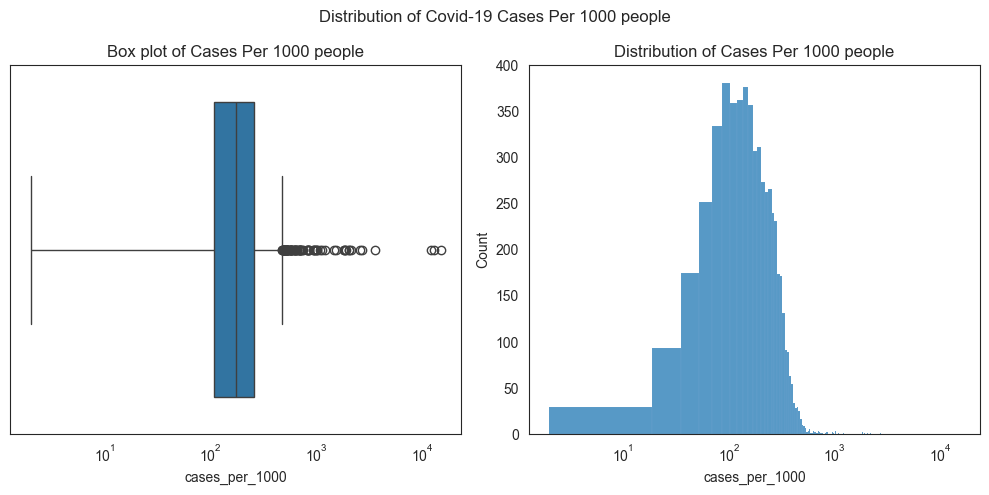

In [13]:
# Plot the Distribution of Covid-19 Cases Per 1000 people
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=df, x='cases_per_1000', ax=ax[0])
sns.histplot(data=df, x='cases_per_1000', ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title('Box plot of Cases Per 1000 people')
ax[1].set_title('Distribution of Cases Per 1000 people')
fig.suptitle("Distribution of Covid-19 Cases Per 1000 people")
plt.tight_layout()
plt.show()

Most regions have cases below 500 per 1,000, There are some potential outliers.

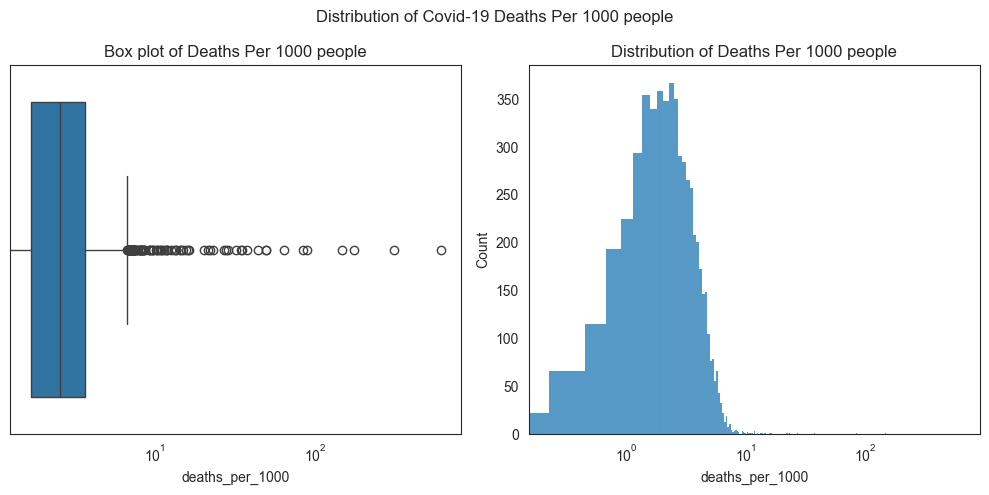

In [14]:
# Plot the Distribution of Covid-19 Cases Per 1000 people
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=df, x='deaths_per_1000', ax=ax[0])
sns.histplot(data=df, x='deaths_per_1000', ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title('Box plot of Deaths Per 1000 people')
ax[1].set_title('Distribution of Deaths Per 1000 people')
fig.suptitle("Distribution of Covid-19 Deaths Per 1000 people")
plt.tight_layout()
plt.show()

Similar trend as cases, with most regions below 10 deaths per 1,000, but some potential outliers too

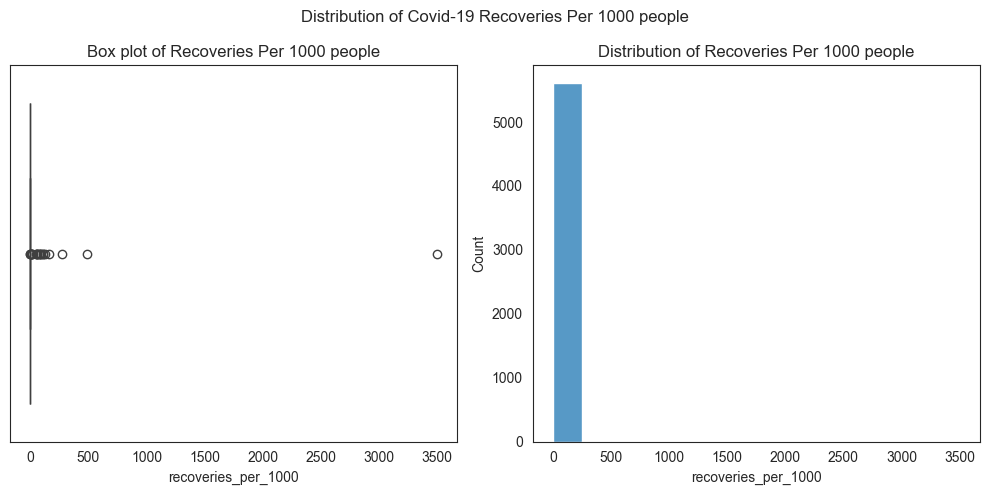

In [15]:
# Plot the Distribution of Covid-19 Recoveries Per 1000 people
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=df, x='recoveries_per_1000', ax=ax[0])
sns.histplot(data=df, x='recoveries_per_1000', ax=ax[1])
ax[0].set_title('Box plot of Recoveries Per 1000 people')
ax[1].set_title('Distribution of Recoveries Per 1000 people')
fig.suptitle("Distribution of Covid-19 Recoveries Per 1000 people")
plt.tight_layout()
plt.show()

The majority of data shows 0 recoveries per 1,000, likely due to incomplete data reporting in some regions. We might drop this column

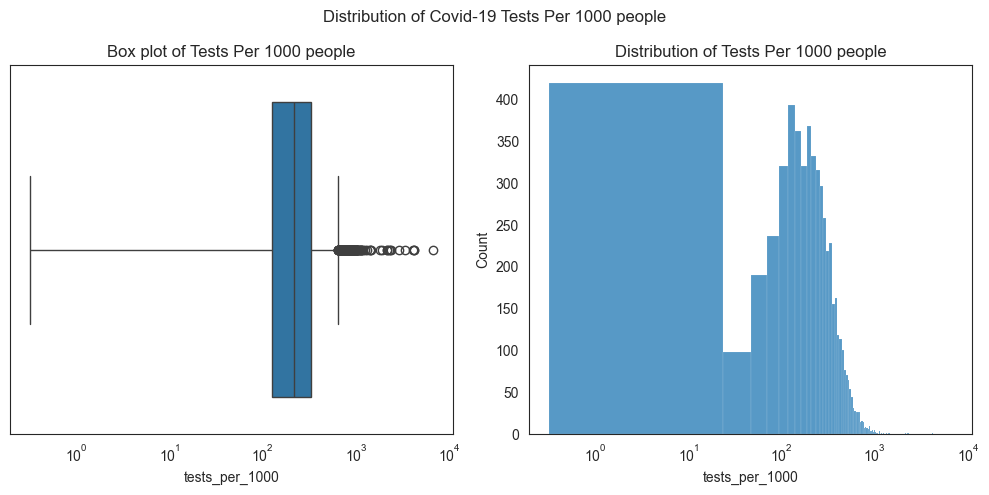

In [16]:
# Plot the Distribution of Covid-19 Tests Per 1000 people
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=df, x='tests_per_1000', ax=ax[0])
sns.histplot(data=df, x='tests_per_1000', ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title('Box plot of Tests Per 1000 people')
ax[1].set_title('Distribution of Tests Per 1000 people')
fig.suptitle("Distribution of Covid-19 Tests Per 1000 people")
plt.tight_layout()
plt.show()

Majority of regions have tests below ~500 per 1,000. Some potential outliers.

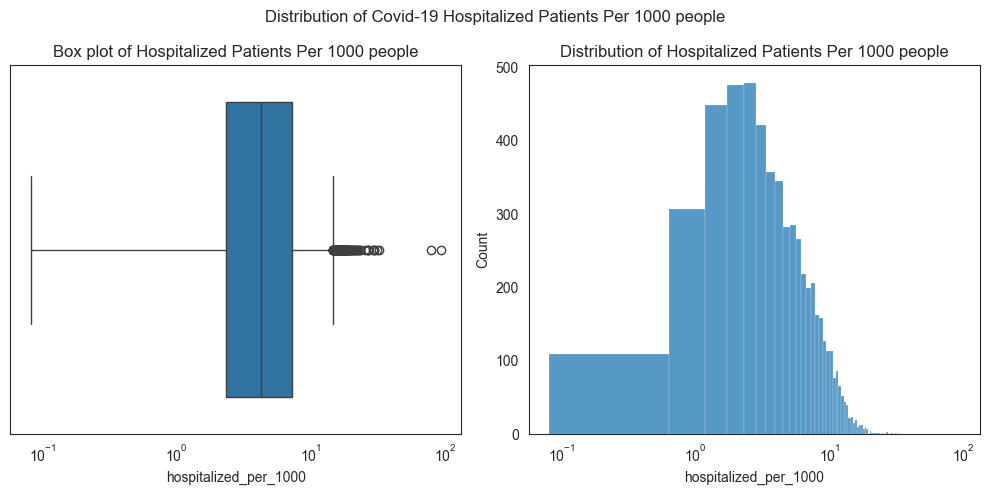

In [17]:
# Plot the Distribution of Covid-19 Hospitalized Patients Per 1000 people
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=df, x='hospitalized_per_1000', ax=ax[0])
sns.histplot(data=df, x='hospitalized_per_1000', ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title('Box plot of Hospitalized Patients Per 1000 people')
ax[1].set_title('Distribution of Hospitalized Patients Per 1000 people')
fig.suptitle("Distribution of Covid-19 Hospitalized Patients Per 1000 people")
plt.tight_layout()
plt.show()

Distributions show heavy concentrations near the lower range (0-10 per 1,000), with fewer regions having higher hospitalization rates.

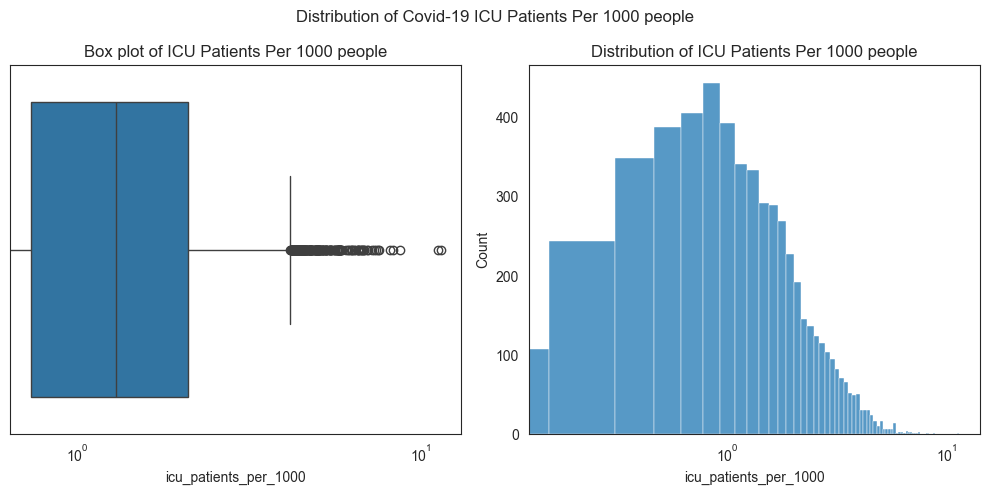

In [18]:
# Plot the Distribution of Covid-19 ICU Patients Per 1000 people
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=df, x='icu_patients_per_1000', ax=ax[0])
sns.histplot(data=df, x='icu_patients_per_1000', ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title('Box plot of ICU Patients Per 1000 people')
ax[1].set_title('Distribution of ICU Patients Per 1000 people')
fig.suptitle("Distribution of Covid-19 ICU Patients Per 1000 people")
plt.tight_layout()
plt.show()

Distributions show heavy concentrations near the lower range (0-10 per 1,000), with fewer regions having higher ICU rates.

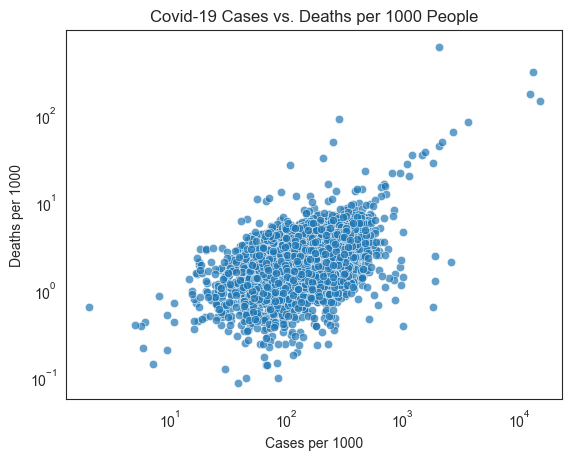

In [19]:
# Covid-19 Cases vs. Deaths
sns.scatterplot(data=df, x='cases_per_1000', y='deaths_per_1000', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cases per 1000')
plt.ylabel('Deaths per 1000')
plt.title('Covid-19 Cases vs. Deaths per 1000 People')
plt.show()

A positive relationsip is visible, deaths increases generally as cases increase.

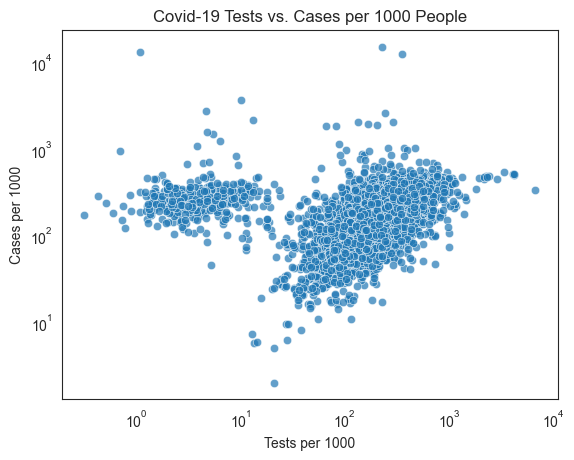

In [20]:
# Covid-19 Tests vs. Cases
sns.scatterplot(data=df, x='tests_per_1000', y='cases_per_1000', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Tests per 1000')
plt.ylabel('Cases per 1000')
plt.title('Covid-19 Tests vs. Cases per 1000 People')
plt.show()

Two distinct clusters are visible:
Low tests (likely regions with less resources).
Higher tests (regions with better financial and medical resouces)

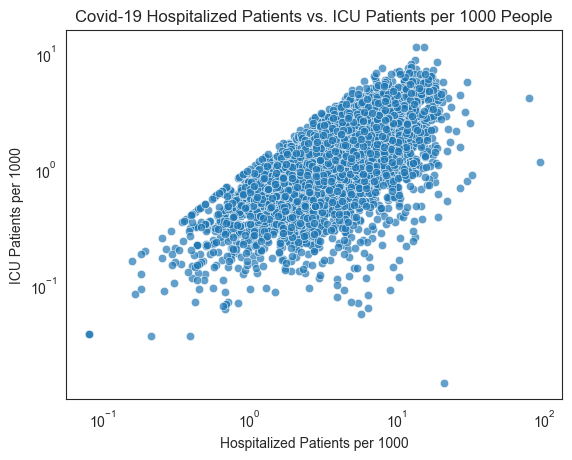

In [21]:
# Covid-19  Hospitalized vs. ICU
sns.scatterplot(data=df, x='hospitalized_per_1000', y='icu_patients_per_1000', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hospitalized Patients per 1000')
plt.ylabel('ICU Patients per 1000')
plt.title('Covid-19 Hospitalized Patients vs. ICU Patients per 1000 People')
plt.show()

Positive relationship, as expected.

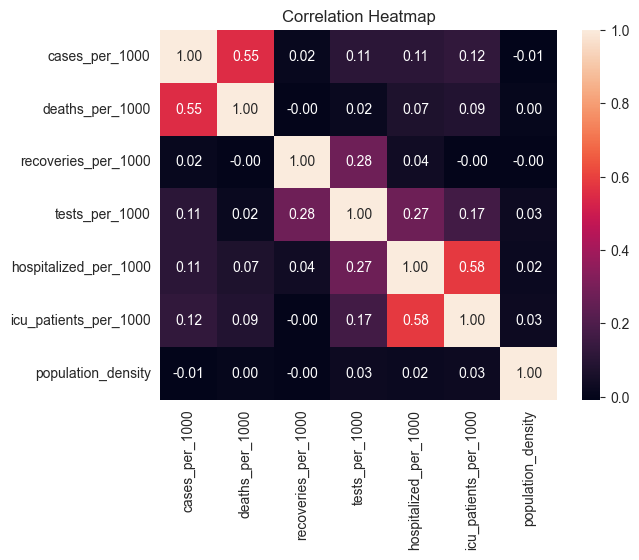

In [22]:
correlation_matrix = df[new_cols].corr()
# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

* Moderate correlation (0.55) between cases_per_1000 and deaths_per_1000.
* Hospitalized_per_1000 and icu_patients_per_1000 have the strongest correlation (0.58).
* Weak correlations among other variables

There are many skewed distribution due to outliers, which could significantly impact clustering.

Method for Handling Outliers:
* Winsorization: Cap extreme values at a percentile threshold (e.g., 1% and 99%) to maintian the structure of the data while reducing the effect of outliers.
* Robust Scaling: After addressing outliers, apply robust scaling to minimize their influence on clustering.

## PREPROCESSING

### WINSORIZATION

In [23]:
# Apply winsorization
for col in new_cols:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])  # Capping at 1st and 99th percentiles

In [24]:
df[new_cols].describe()

,cases_per_1000,deaths_per_1000,recoveries_per_1000,tests_per_1000,hospitalized_per_1000,icu_patients_per_1000,population_density
count,5608.000000,5608.000000,5608.0,5608.000000,5608.000000,5608.000000,5608.000000
mean,191.260907,2.793338,0.0,246.706000,5.194089,1.576288,121.707582
std,106.657521,1.506854,0.0,174.272697,3.656625,1.125463,472.464501
min,25.250073,0.380373,0.0,1.913043,0.455201,0.091458,0.732767
25%,108.636448,1.665719,0.0,126.499876,2.344386,0.729576,11.794293
50%,174.708292,2.555507,0.0,217.188502,4.255357,1.299407,24.739351
75%,257.140415,3.663004,0.0,333.333333,7.255877,2.108479,54.578895
max,566.884532,8.083141,0.0,876.780627,17.439703,5.446795,3842.701258


* The ranges are now much more reasonable after winsorization
* The recoveries_per_1000 column show 0 values all through, There was likely errors in the survey reporting, and so it will be dropped

In [25]:
# select all the columns to be used for clustering
# keep latitude and logitude to retain geographical information too
selected_cols = ['latitude', 'longitude', 'cases_per_1000', 'deaths_per_1000', 'tests_per_1000', 
                 'hospitalized_per_1000', 'icu_patients_per_1000', 'population_density']

In [26]:
# separate our data
X = df[selected_cols]
print(X.shape)
X.head()

(5608, 8)


,latitude,longitude,cases_per_1000,deaths_per_1000,tests_per_1000,hospitalized_per_1000,icu_patients_per_1000,population_density
0,-14.000000,-53.000000,162.631394,3.223583,333.663023,5.668067,1.807363,24.960680
1,-9.047778,-70.526389,203.840455,2.765967,314.216034,3.709313,0.359889,4.807669
2,-9.827778,-66.882778,258.015632,3.190301,618.918488,8.853087,1.276121,3842.701258
3,-10.911389,-69.582500,355.072464,4.117260,748.188406,1.811594,0.658762,3036.000000
4,-11.010000,-68.747778,184.877091,2.383400,441.910459,0.794467,0.280400,3842.701258


### Robust Scaling

In [27]:
# Apply Robust scaler
scaler = RobustScaler()
X = scaler.fit_transform(X)
# View the scaled variables
pd.DataFrame(X, columns=scaler.get_feature_names_out()).head()

,latitude,longitude,cases_per_1000,deaths_per_1000,tests_per_1000,hospitalized_per_1000,icu_patients_per_1000,population_density
0,0.279445,-0.682825,-0.081324,0.334493,0.563132,0.287634,0.368377,0.005173
1,0.623573,-2.526768,0.196171,0.105373,0.469109,-0.111177,-0.681352,-0.465861
2,0.569371,-2.143426,0.560977,0.317829,1.942287,0.936117,-0.016888,89.236822
3,0.494072,-2.427462,1.214541,0.781938,2.567282,-0.497560,-0.464605,70.381878
4,0.487219,-2.339641,0.068475,-0.086170,1.086487,-0.704652,-0.738999,89.236822


## K-MEANS CLUSTERING

In [28]:
# create empty lists for Within Cluster Sum of Squares and Silhuette Scores
WCSS = []
silhouette_scores = []

# run kmeans for the range 2 to 9
for k in range(2,10):
    # create kmeans object and fit to X
    kmeans = KMeans(n_clusters=k, random_state=random_seed)
    kmeans.fit(X)
    # append the sum of square distances within clusters (inertia)
    WCSS.append(kmeans.inertia_)
    # get and append the silhuoette score
    scores = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(scores)

In [29]:
# create the df for the WCSS and Silhuoette Scores
kvalues_df = pd.DataFrame({'K': list(range(2,10)), 'WCSS':WCSS, 'Silhouette':silhouette_scores})
kvalues_df.head()

,K,WCSS,Silhouette
0,2,111351.917307,0.943467
1,3,58832.388442,0.884786
2,4,43254.080703,0.704911
3,5,37250.098051,0.283017
4,6,29071.457209,0.282846


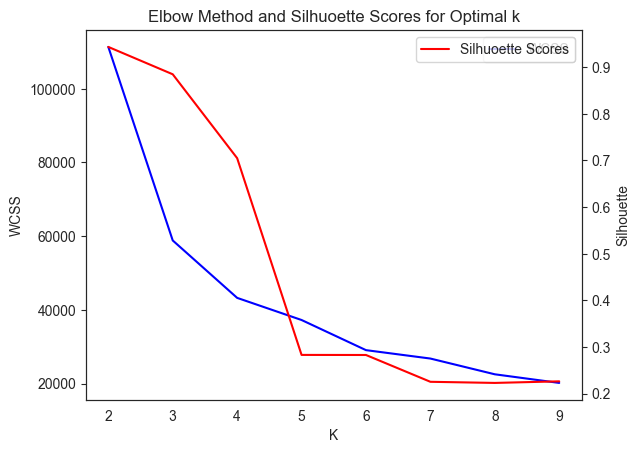

In [30]:
# Plot elbow method
sns.lineplot(data=kvalues_df, x='K', y='WCSS', color='blue', label='WCSS')
plt.legend()
# create a second y axis and plot the silhuoette scores
ax2 = plt.twinx()
sns.lineplot(data=kvalues_df, x='K', y='Silhouette', ax=ax2, color='red', label='Silhuoette Scores')
plt.title('Elbow Method and Silhuoette Scores for Optimal k')
plt.legend()
plt.show()

Blue line: WCSS, Red Line: Silhuoette Scores

There are noticebale elbows at k=3, and k=4. However k=3 has a much higher silhuoette score, therefore, the optimal k = 3

In [31]:
# apply kmeans with optimal k=3
kmeans_opt = KMeans(n_clusters=3, random_state=random_seed)
kmeans_cluster = kmeans_opt.fit_predict(X)
kmeans_cluster

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

## HIERARCHICAL CLUSTERING

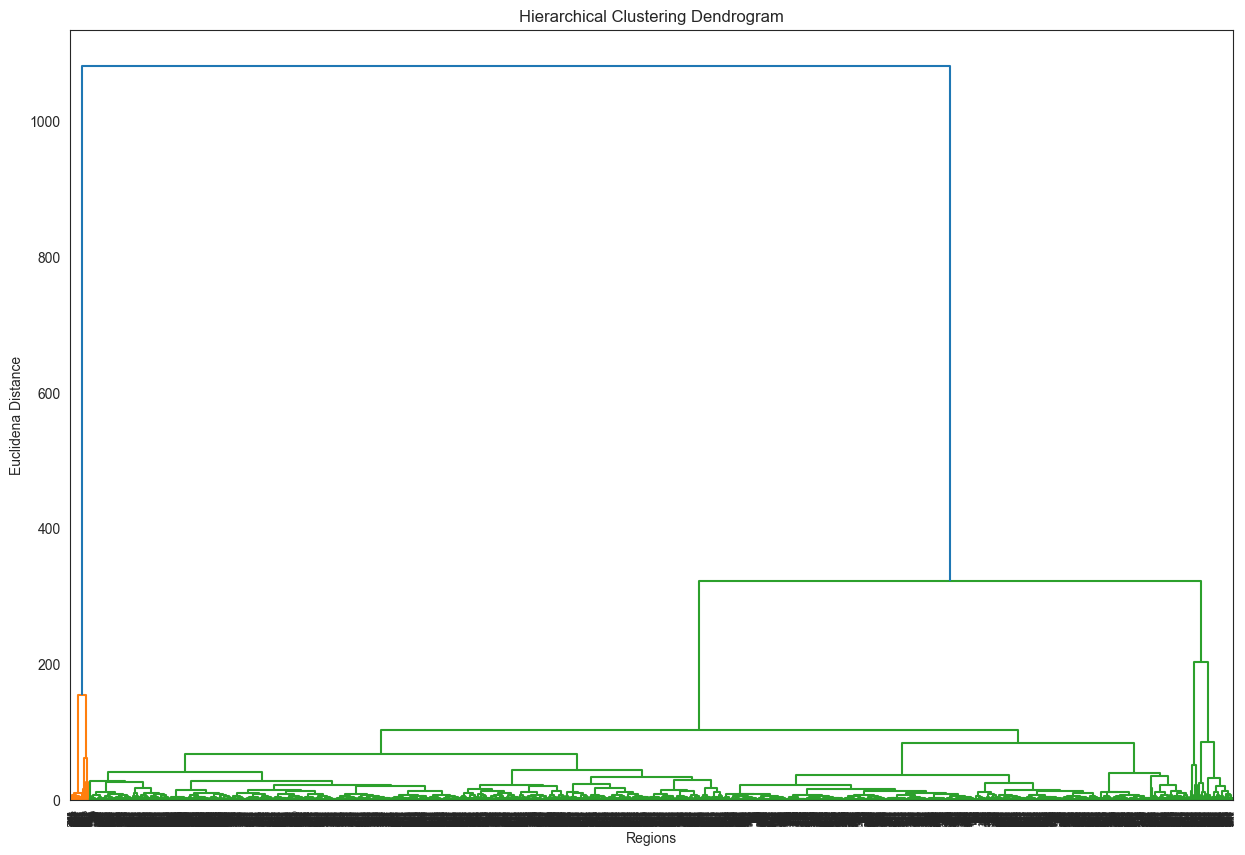

In [32]:
# Create the dendogram
plt.figure(figsize=(15,10))
dendog = dendrogram(linkage(X, method='ward'))
plt.xlabel('Regions') 
plt.ylabel('Euclidena Distance') 
plt.title('Hierarchical Clustering Dendrogram') 
plt.savefig("Dendogram.png")
plt.show()

## AGGLOMERATIVE CLUSTERING

In [33]:
# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
agglo_cluster = agglo.fit_predict(X)

In [34]:
# compare silhuoette scores
kmeans_silhuoette = silhouette_score(X, kmeans_cluster)
agglo_silhuoette = silhouette_score(X, agglo_cluster)
print(f'Silhuoette Scores: Kmeans = {round(kmeans_silhuoette,2)}, Agglomerative = {round(agglo_silhuoette,2)}')

Silhuoette Scores: Kmeans = 0.88, Agglomerative = 0.79


KMEANS has a higher silhuoette score of 0.88

In [35]:
# create a copy of the df to add the clusters
df_clusters = df[selected_cols].copy()
df_clusters['Cluster'] = kmeans_cluster
df_clusters.head()

,latitude,longitude,cases_per_1000,deaths_per_1000,tests_per_1000,hospitalized_per_1000,icu_patients_per_1000,population_density,Cluster
0,-14.000000,-53.000000,162.631394,3.223583,333.663023,5.668067,1.807363,24.960680,0
1,-9.047778,-70.526389,203.840455,2.765967,314.216034,3.709313,0.359889,4.807669,0
2,-9.827778,-66.882778,258.015632,3.190301,618.918488,8.853087,1.276121,3842.701258,1
3,-10.911389,-69.582500,355.072464,4.117260,748.188406,1.811594,0.658762,3036.000000,1
4,-11.010000,-68.747778,184.877091,2.383400,441.910459,0.794467,0.280400,3842.701258,1


## PCA

In [36]:
# initialize PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [37]:
# check the explained variance ratio for each PCA
pca.explained_variance_ratio_

array([0.96861847, 0.01474042])

In [38]:
# the total sum of the explain varaince
sum(pca.explained_variance_ratio_)

np.float64(0.9833588935841228)

Over 98% of the original variance is explained by the two dimensions PCA1 and PCA2

In [39]:
# create a df to to show the pca components and the clusters
pca_df = pd.DataFrame(X_reduced, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = kmeans_cluster
pca_df.head()

,PCA1,PCA2,Cluster
0,-2.258163,0.471940,0
1,-2.745560,0.207722,0
2,86.966638,0.837014,1
3,68.108097,0.894246,1
4,86.948732,-0.809424,1


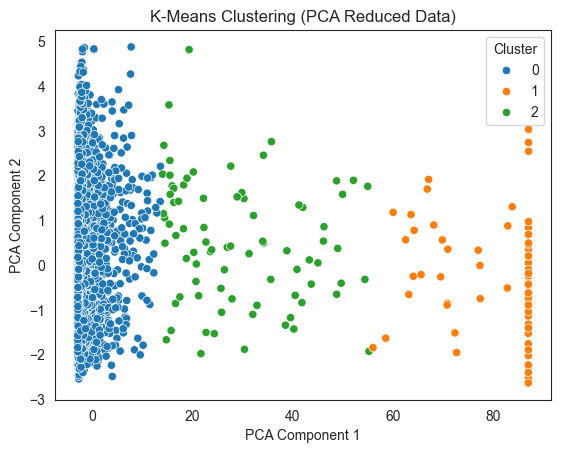

In [40]:
# Visualize the clusters using the PCA components
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering (PCA Reduced Data)')
plt.legend(title='Cluster')
plt.show()

The PCA visualization showed well-separated clusters, confirming the suitability of K=3 for K-Means.

## INTERPRETATION

In [41]:
# Get the cluster means
cluster_means = df_clusters.groupby('Cluster').mean().round(2)
cluster_means

,latitude,longitude,cases_per_1000,deaths_per_1000,tests_per_1000,hospitalized_per_1000,icu_patients_per_1000,population_density
Cluster,,,,,,,,
0,-16.17,-46.20,191.87,2.76,245.28,5.15,1.56,48.24
1,-18.18,-46.15,157.17,3.66,271.92,6.12,1.90,3608.17
2,-18.53,-45.41,185.70,3.98,313.23,7.30,2.15,1377.55


In [42]:
# get the cluster means of the original df (with the cummulative metrics)
# add the clusters to the df
df['cluster'] = kmeans_cluster
# select the relevant colummns
cols = ['cumulative_confirmed', 'cumulative_deceased', 'cumulative_tested', 
        'cumulative_hospitalized_patients', 'cumulative_intensive_care_patients', 'population', 'cluster']
cluster_means_cummulative = df[cols].groupby('cluster').mean().round(2)
cluster_means_cummulative

,cumulative_confirmed,cumulative_deceased,cumulative_tested,cumulative_hospitalized_patients,cumulative_intensive_care_patients,population
cluster,,,,,,
0,26267.92,383.61,89408.81,898.40,212.25,118009.23
1,126765.19,3922.54,223182.32,6536.64,2296.76,907513.15
2,58434.05,1363.92,110202.39,2361.13,796.46,327957.21


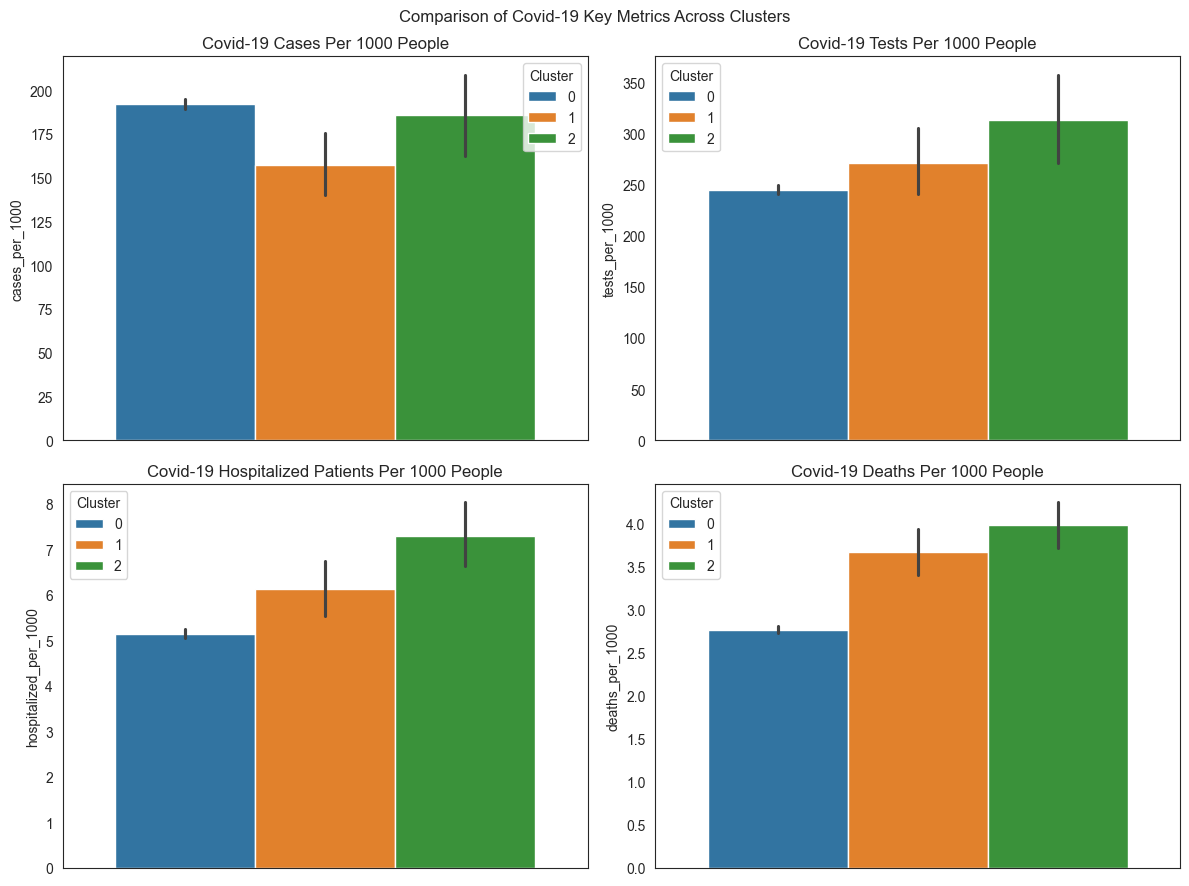

In [43]:
# Plot the key metrics accross the cluster
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,9))

sns.barplot(data=df_clusters, y='cases_per_1000', hue='Cluster', ax=ax[0,0] ,palette='tab10')
sns.barplot(data=df_clusters, y='deaths_per_1000', hue='Cluster', ax=ax[1,1] ,palette='tab10')
sns.barplot(data=df_clusters, y='hospitalized_per_1000', hue='Cluster', ax=ax[1,0] ,palette='tab10')
sns.barplot(data=df_clusters, y='tests_per_1000', hue='Cluster', ax=ax[0,1] ,palette='tab10')

# add titles for each plot
ax[0,0].set_title("Covid-19 Cases Per 1000 People")
ax[1,1].set_title("Covid-19 Deaths Per 1000 People")
ax[1,0].set_title("Covid-19 Hospitalized Patients Per 1000 People")
ax[0,1].set_title("Covid-19 Tests Per 1000 People")

# add a general title
plt.suptitle("Comparison of Covid-19 Key Metrics Across Clusters")
plt.tight_layout()
plt.savefig("ClusterComparisons.png")
plt.show()

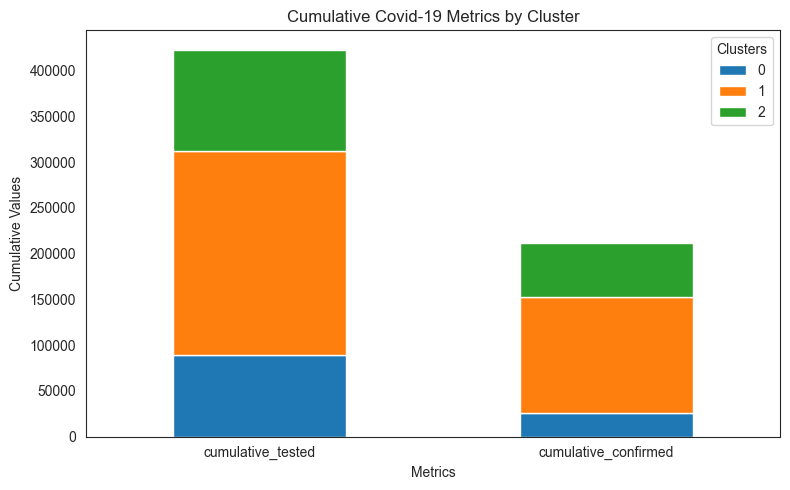

In [44]:
# plot the cummulative metrics per cluster
cumulative_metrics = ['cumulative_tested', 'cumulative_confirmed',]
stacked_data = cluster_means_cummulative[cumulative_metrics].T

stacked_data.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Cumulative Covid-19 Metrics by Cluster")
plt.xlabel("Metrics")
plt.xticks(rotation=0)
plt.ylabel("Cumulative Values")
plt.legend(title="Clusters")
plt.tight_layout()
plt.show()


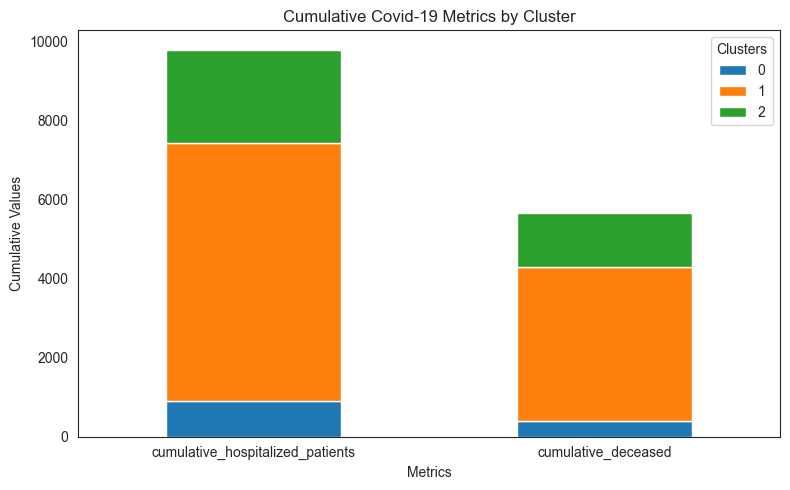

In [45]:
# plot the cummulative metrics per cluster
cumulative_metrics = ['cumulative_hospitalized_patients', 'cumulative_deceased']
stacked_data = cluster_means_cummulative[cumulative_metrics].T

stacked_data.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Cumulative Covid-19 Metrics by Cluster")
plt.xlabel("Metrics")
plt.xticks(rotation=0)
plt.ylabel("Cumulative Values")
plt.legend(title="Clusters")
plt.tight_layout()
plt.show()
